In [2]:
!pip install pymodis -q

### Define function

In [3]:
def sliding_window(img, step, window_size):
  """
  INPUT:
  img = input image
  step = the distance (in pixels, for both horizontal and vertical direction) 
  between 2 windows
  window_size = size of the sliding window, format: (pixels(y-axis),pixels(x-axis))

  OUTPUT: (x,y,window)
  x,y: the coordinates of the top left corner of the current window (in pixels) 
  in the coordinate system of "img".
  window: the current window, size = (window_size)
  """
  for y in range(0, img.shape[0], step):
    for x in range(0, img.shape[1], step):
      yield (x, y, img[y:y + window_size[1], x:x + window_size[0]])

In [39]:
def read_tif(in_file):
  """
  Similar to read_modis but this function is for reading output .tif file from
  """
  # save_tif()

  dataset =  gdal.Open(in_file, gdal.GA_ReadOnly)

  cols =dataset.RasterXSize
  rows = dataset.RasterYSize
  projection = dataset.GetProjection()
  geotransform = dataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  coords=np.asarray((geotransform[0],geotransform[3]))

  # Open dataset Day as np.array()
  band = dataset.GetRasterBand(1)
  LST_K_day = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # open dataset Night as np.array()
  band = dataset.GetRasterBand(2)
  LST_K_night = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  return LST_K_day,LST_K_night,cols,rows,projection,geotransform

def save_tif(out_file, LST_K_day, LST_K_night, cols, rows, projection, geotransform):
  """
  INPUT:
  out_file: directory + name of output tif file (e.g a/b/c/MOD11A1.tif)
  LST_K_day, LST_K_night, cols, rows, projection, geotransform: read read_modis

  OUTPUT:
  A .tif file having 2 bands(1 for day, 1 for night)
  """

  bands = 2
  day_night_imgs = np.zeros((2,LST_K_day.shape[0],LST_K_day.shape[1]))
  day_night_imgs[0,:,:]= LST_K_day
  day_night_imgs[1,:,:]= LST_K_night

  driver = gdal.GetDriverByName("GTiff")
  outDs = driver.Create(out_file, day_night_imgs.shape[1], day_night_imgs.shape[2], bands, gdal.GDT_Float32) 
  outDs.SetProjection(projection)
  outDs.SetGeoTransform(geotransform) 

  for i in range(1,bands+1):
      outBand = outDs.GetRasterBand(i)
      outBand.WriteArray(day_night_imgs[i-1,:,:])
      outDs.FlushCache()

In [37]:
def read_modis(in_file):
  """
  This function is for reading modis file in format "x.hdf" contained in 
  in_file parameter.
  INPUT: 
  in_file: path to hdf file
  to be completed if we need more stuffs

  OUTPUT:
  LST_K_day and LST_K_night: Day and Night LST image arrays
  cols, rows: numbers of pixels alongs x,y axes of each raster
  projection: projection information
  geotransform: georeferencing information
  # georef format = (x-coor top left pixel,resX,0,y-coor top left pixel,rexY,0)
  to be completed if we need more information (georeference,bands,etc.)
  """
  # open dataset Day
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[0][0], gdal.GA_ReadOnly)

  cols =subdataset.RasterXSize
  rows = subdataset.RasterYSize
  projection = subdataset.GetProjection()
  geotransform = subdataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  # coords=np.asarray((geotransform[0],geotransform[3]))

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  # bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_day=0.02*LST_raw

  # open dataset Night
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[4][0], gdal.GA_ReadOnly)

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  # bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_night=0.02*LST_raw

  # return LST_K_day, LST_K_night
  return LST_K_day, LST_K_night, cols, rows, projection, geotransform


def crop_modis(hdf_path, hdf_name, save_dir, save_dir_downsample,step=64,size=(64,64)):
  """
  INPUT:
  hdf_path = input image path to be cropped | or hdf file path ("/a/b/c.hdf")
  save_dir = directory for saving cropped images
  step, size: parameters of "sliding_window()"

  OUTPUT: images cropped from the image in hdf_path, saved to save_dir
  """
  if not hdf_path.endswith('hdf'): 
    print("Not hdf file Sorry!")
    return 

  img_day, img_night, cols, rows, projection, geotransform = read_modis(hdf_path)
  
  img_days = []
  img_nights = []
  img_cropped_names = []
  geotransform2s = []
  cols2, rows2 = size

  if img_day is None or img_night is None:
    print("Cannot handle this MODIS file: ", hdf_path, ". Please check it again")
    return
  # For day image
  win_count = 0
  for (x,y,window) in sliding_window(img_day, step, size):
      if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue

      img_cropped_name = hdf_name + ".{}.tif".format(str(win_count).zfill(4))
      img_cropped = window
      geotransform2 = np.asarray(geotransform)
      geotransform2[0] = geotransform[0]+x*geotransform[1] # 1st coordinate of top left pixel of the image 
      geotransform2[3] = geotransform[3]+y*geotransform[5] # 2nd coordinate of top left pixel of the image
      geotransform2=tuple(geotransform2)

      img_cropped_names.append(img_cropped_name)
      img_days.append(img_cropped)
      geotransform2s.append(geotransform2)
      
      win_count += 1
  print("Number of cropped day images", win_count)

  # For night image
  win_count = 0
  for (x,y,window) in sliding_window(img_night, step, size):
    if window.shape[0] != size[0] or window.shape[1] != size[1]:
        continue
    # save_path = os.path.join(save_dir,img_cropped_name)
    img_cropped = window
    # np.save(save_path,img_cropped)
    img_nights.append(img_cropped)
    win_count += 1
  print("Number of cropped night images", win_count)
  
  # Save images and metadata into .tif file
  for i in range(len(img_cropped_names)):
    save_path = os.path.join(save_dir,img_cropped_names[i])
    save_tif(save_path, img_days[i], img_nights[i], cols2, rows2, projection, geotransform2s[i])

    save_path_downsample = os.path.join(save_dir_downsample,img_cropped_names[i])
    img_day_downsample = skimage.measure.block_reduce(img_days[i],(2,2),np.mean)
    img_night_downsample = skimage.measure.block_reduce(img_nights[i],(2,2),np.mean)
    save_tif(save_path_downsample, img_day_downsample, img_night_downsample, cols2, rows2, projection, geotransform2s[i])




In [47]:
def cloud_sea_eliminate(tifs_folder):
  """
  INPUT
  dir: the directory containing cropped TIF file from which we want to eliminate 
  the ones having cloud and sea

  OUTPUT
  there is not any output, just the images containing cloud or sea pixels (>15% the number of pixels)  
  will be eliminated from the directory
  """
  tifs = os.listdir(tifs_folder)

  for i,tif in enumerate(tifs):
    if not tif.endswith('tif'): continue
    tif_path = os.path.join(tifs_folder, tif)
    LST_K_day, LST_K_night, cols, rows, projection, geotransform = read_tif(tif_path)
    num_px = cols*rows
    thres = 0.15 # Threshold: maximum number of sea/cloud pixels
    if len(LST_K_day[LST_K_day==0.0]) > thres*num_px or len(LST_K_night[LST_K_night==0.0]) > thres*num_px:
      os.remove(tif_path)
      print("Too much cloud or sea pixels! Remove: {}".format(tif_path))

### Download Raw MODIS Dataset

In [26]:
import os
import glob
from pymodis import downmodis
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import skimage.measure


In [23]:
hdfs_path           = 'dataset/hdfs_files'
npys_1km_path       = 'dataset/npys_files/1km'
npys_1km_Day_path   = 'dataset/npys_files/1km/Day'
npys_1km_Night_path = 'dataset/npys_files/1km/Night'
npys_4km_path       = 'dataset/npys_files/4km'

tifs_1km_path       = 'dataset/tifs_files/1km'
tifs_2km_path       = 'dataset/tifs_files/2km'

os.makedirs(hdfs_path,exist_ok=1)
os.makedirs(npys_1km_path,exist_ok=1)
os.makedirs(npys_1km_Day_path,exist_ok=1)
os.makedirs(npys_1km_Night_path,exist_ok=1)
os.makedirs(npys_4km_path,exist_ok=1)

os.makedirs(tifs_1km_path,exist_ok=1)
os.makedirs(tifs_2km_path,exist_ok=1)


In [6]:
# tiles to download
tiles = "h18v04" # string of tiles separated by comma
# starting day
startdate = "2020-01-01"
# end day
enddate = "2020-01-02"
# product names ("MOD11A1.061" and "MYD11A1.061")
# Example (Carlos sent us) "MOD11A1.A2021274.h18v04.061.2021278094039.hdf"
products = "MOD11A1.061" # product name as on the http/ftp server
# Initialize downmodis module
modisDown = downmodis.downModis(user="projet3a",password="Projet3AIMT",product=products,destinationFolder=hdfs_path, tiles=tiles, today=startdate, enddate=enddate)
modisDown.connect()

modisDown.downloadsAllDay()


### Crop image and save as tif format

In [ ]:
hdfs = os.listdir(hdfs_path)
for hdf in hdfs:
  if not hdf.endswith('hdf'): continue

  hdf_path = os.path.join(hdfs_path,hdf)
  print("hdf_path is: ",hdf_path)
  
  crop_modis(hdf_path, hdf,tifs_1km_path, tifs_2km_path, 64, (64,64))
  # LST_K_day_, LST_K_night_, cols_, rows_, projection_, geotransform_ = read_tif("dataset/tifs_files/1km/MOD11A1.A2020011.h18v04.061.2021003203846.hdf.0000.tif")

cloud_sea_eliminate(tifs_1km_path)
cloud_sea_eliminate(tifs_2km_path)

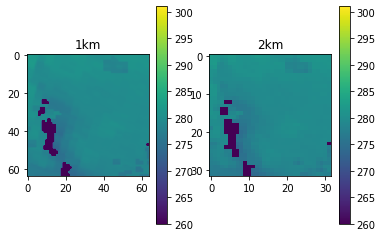

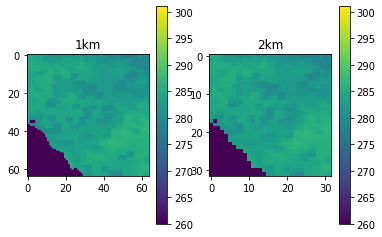

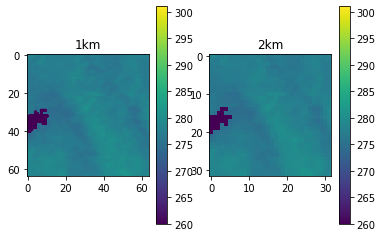

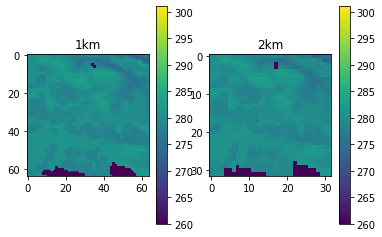

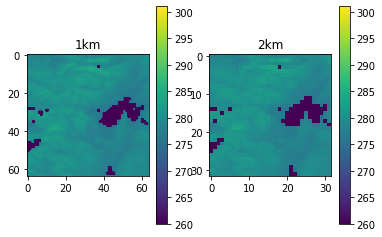

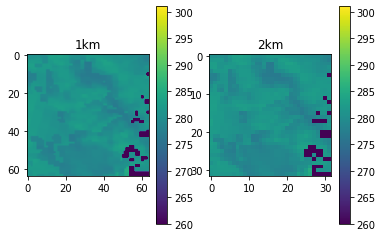

In [49]:
tifs = os.listdir(tifs_1km_path)

for i,tif in enumerate(tifs):
  if i>5: break # just for demo
  if not tif.endswith('tif'): continue
  tif_1km_path = os.path.join(tifs_1km_path, tif)
  tif_2km_path = os.path.join(tifs_2km_path, tif)
  LST_K_day_1km, LST_K_night_1km, cols_1km, rows_1km, projection_1km, geotransform_1km = read_tif(tif_1km_path)
  LST_K_day_2km, LST_K_night_2km, cols_2km, rows_2km, projection_2km, geotransform_2km = read_tif(tif_2km_path)

  plt.figure()
  plt.subplot(121)
  plt.imshow(LST_K_day_1km)
  plt.clim(260,301)
  plt.colorbar()
  plt.title("1km")
  plt.subplot(122)
  plt.imshow(LST_K_day_2km)
  plt.clim(260,301)
  plt.colorbar()
  plt.title("2km")
  plt.show()
plt.close()

### Extract image array to npy

In [50]:
hdfs = os.listdir(hdfs_path)

for hdf in hdfs:
  if not hdf.endswith('hdf'): continue

  hdf_path = os.path.join(hdfs_path,hdf)
  print("hdf_path",hdf_path)
  # open dataset Day
  dataset = gdal.Open(hdf_path,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[0][0], gdal.GA_ReadOnly)

  cols =subdataset.RasterXSize
  rows = subdataset.RasterYSize
  projection = subdataset.GetProjection()
  geotransform = subdataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  coords=np.asarray((geotransform[0],geotransform[3]))

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_day=0.02*LST_raw

  # plt.figure(figsize=(50,50))
  # plt.imshow(LST_K_day)
  # plt.clim(260,301)
  # plt.colorbar()

  # open dataset Night
  dataset = gdal.Open(hdf_path,gdal.GA_ReadOnly)

  subdataset =  gdal.Open(dataset.GetSubDatasets()[4][0], gdal.GA_ReadOnly)

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_night=0.02*LST_raw

  # plt.figure(figsize=(50,50))
  # plt.imshow(LST_K_night)
  # plt.clim(260,301)
  # plt.colorbar()

  npy_path = os.path.join(npys_1km_path,"Day",hdf)
  np.save(npy_path,LST_K_day)
  npy_path = os.path.join(npys_1km_path,"Night",hdf)
  np.save(npy_path,LST_K_night)


hdf_path dataset/hdfs_files/MOD11A1.A2020002.h18v04.061.2021003094902.hdf
hdf_path dataset/hdfs_files/MOD11A1.A2020001.h18v04.061.2021003092415.hdf


### Demo

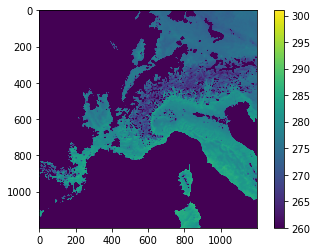

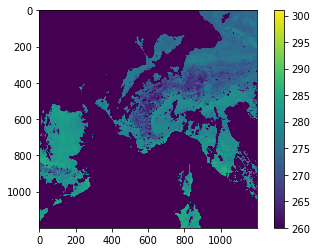

In [51]:

imgs = os.listdir(npys_1km_Day_path)

for img in imgs:
# if 1:
  # img = imgs[0]
  # Load Day npy file
  npy_path = os.path.join(npys_1km_Day_path,img)
  LST_K_day = np.load(npy_path)

  plt.figure()
  plt.imshow(LST_K_day)
  plt.clim(260,301)
  plt.colorbar()

### Show dataset structure

In [52]:
!apt install tree
!tree dataset

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
dataset
├── hdfs_files
│   ├── listfileMOD11A1.061.txt
│   ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf
│   ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf.xml
│   ├── MOD11A1.A2020002.h18v04.061.2021003094902.hdf
│   ├── MOD11A1.A2020002.h18v04.061.2021003094902.hdf.xml
│   └── modisMOD11A1.061.log
├── npys_files
│   ├── 1km
│   │   ├── Day
│   │   │   ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf.npy
│   │   │   └── MOD11A1.A2020002.h18v04.061.2021003094902.hdf.npy
│   │   └── Night
│   │       ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf.npy
│   │       └── MOD11A1.A2020002.h18v04.061.2021003094902.hdf.npy
│   └── 4km
└── tifs_files
    ├── 1km
    │   ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf.0013.tif
    │   ├── MOD11A1.A2020001.h18v04.061.2021003092415.h